# Lab 2
## Medical Patient No Show

### Team members: Luay Dajani, Dana Geislinger, Chris Morgan, Caroll Rodriguez
##### Github - https://github.com/cdmorgan103/7331DataMiningNoShow

MSDS 7331, 10/28/2018

In [1]:
import numpy as np
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
from IPython.display import display
import seaborn as sns; sns.set(font_scale=1.2)
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit 
import datetime 
from sklearn.model_selection import TimeSeriesSplit


# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load the data into variable 'df' from pickled object
from funcs import load_df
df = load_df()

## Data Preparation Part 1
#### [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

**Meetings Notes:** Chris, Luay, Caroll - Add Dimensionality reduction and scaling from Mini Lab.
Variable to remove - AppointmentID & PatientID
Luay to add dimensionality reduction

In [2]:
#Remove attributes not usefull
del df['PatientId']
del df['AppointmentID']

# perform one-hot encoding of the categorical data 
tmp_df = pd.get_dummies(df.Handicap,prefix='Handicap')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.AppointmentDOW,prefix='AppointmentDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.ScheduledDOW,prefix='ScheduledDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.Neighbourhood,prefix='Neighbourhood')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.age_range,prefix='age_range')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# replace the current Gender attribute with something slightly more intuitive and readable
df['IsMale'] = df.Gender=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Now let's clean up the dataset
if 'Gender' in df:
    del df['Gender'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Handicap' in df:    
    del df['Handicap'] # get rid of the original category as it is now one-hot encoded
    
if 'ScheduledDOW' in df:    
    del df['ScheduledDOW'] # get rid of the original category as it is now one-hot encoded
    
if 'AppointmentDOW' in df:    
    del df['AppointmentDOW'] # get rid of the original category as it is now one-hot encoded

if 'Neighbourhood' in df:    
    del df['Neighbourhood'] # get rid of the original category as it is now one-hot encoded

if 'age_range' in df:
    del df['age_range']

if 'AppointmentID' in df:
    del df['AppointmentID']
    
#if 'ScheduledDay' in df:
   #del df['ScheduledDay']
    
#if 'ScheduledTime' in df:
    #del df['ScheduledTime']

#if 'AppointmentDay' in df:
 #   del df['AppointmentDay']

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Columns: 115 entries, ScheduledDay to IsMale
dtypes: bool(1), datetime64[ns](2), int32(1), int64(7), object(1), uint8(103)
memory usage: 19.8+ MB


In [3]:
print(df.dtypes)

ScheduledDay                      datetime64[ns]
ScheduledTime                             object
AppointmentDay                    datetime64[ns]
Age                                        int64
Scholarship                                int64
Hypertension                               int64
Diabetes                                   int64
Alcoholism                                 int64
SMSReceived                                int64
NoShow                                      bool
DaysInAdvance                              int64
Handicap_0                                 uint8
Handicap_1                                 uint8
Handicap_2                                 uint8
Handicap_3                                 uint8
Handicap_4                                 uint8
AppointmentDOW_Monday                      uint8
AppointmentDOW_Tuesday                     uint8
AppointmentDOW_Wednesday                   uint8
AppointmentDOW_Thursday                    uint8
AppointmentDOW_Frida

In [4]:
df.describe()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMSReceived,DaysInAdvance,Handicap_0,Handicap_1,Handicap_2,...,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,age_range_child,age_range_adult,age_range_senior,IsMale
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,...,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.089218,0.098266,0.197246,0.071865,0.030400,0.321026,10.183792,0.979724,0.018475,0.001656,...,0.016611,0.017887,0.022148,0.028337,0.001375,0.007699,0.234060,0.645598,0.120342,0.350023
std,23.109921,0.297675,0.397921,0.258265,0.171686,0.466873,15.254924,0.140942,0.134662,0.040657,...,0.127811,0.132541,0.147167,0.165934,0.037059,0.087409,0.423412,0.478334,0.325362,0.476979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,179.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#simple export of final dataset
df.to_csv("./data/df.csv", sep=',')

## Data Preparation Part 2
#### [5 points] Describe the ﬁnal dataset that is used for classiﬁcation/regression (include a description of any newly formed variables you created).

**Meeting Notes:** Luay wants add a field that ranks the patient's no show history. If they showed up twice and didn't show up 1 would be 33%. Create a temp dataset to group Patient and determine the # of no shows then merge the dataset and build the ranking. 

https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

## Modeling and Evaluation 1

#### [10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

**Meeting Notes:** Was in Lab1. Chris wants to add a better explaination of accuracy.

## Modeling and Evaluation 2	

#### [10 points]	Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

**Meeting Notes:** Caroll to find code for splitting time series data.

##### Partioning Data
We want to forecast future NoShows based on Appointment dates. We take the data we have and build a fixed training period in the past up to the last month. The last month of data will be used as testing dataset. Before we deploy the model we will rerun the models utilizing the entire dataset to predict the future outcomes.
This approach fits our dataset since we there is correlation between the appoointme date and whether or not they no-show.

In [6]:
#Testing set --- hold 1 month of data out as test set based on AppointmentDay
df_test = df.copy()
X_test = df_test[(df_test['AppointmentDay'] >= datetime.date(2016,5,25))]

y_test = X_test['NoShow'].values # get the labels we want.

if 'NoShow' in X_test:
    del X_test['NoShow'] # get rid of the class label

#Training set -- all records less than appointment date 5/1/2016
df_train = df.copy()
X_train = df_train[(df_train['AppointmentDay'] < datetime.date(2016,5,25))]
  
y_train = X_train['NoShow'].values # get the labels we want.
del X_train['NoShow'] # get rid of the class label

if 'NoShow' in X_train:
    del X_train['NoShow'] # get rid of the class label

df_tmp = df.copy()
X = df_tmp
y = df_tmp['NoShow']
if 'NoShow' in X:
    del X['NoShow'] # get rid of the class label

In [8]:
print ('Number of Prediciting Features: ', X.shape)
print ('Number of Response: ', y.shape)
print ('Appointment Date Range (Trainig Set): ', min(X_train['AppointmentDay']) ,  max(X_train['AppointmentDay']))
print ('Number of Training Records: ', X_train.shape)
print ('Number of Test Records: ', X_test.shape)
print ('Appointment Date Range (Test Set): ', min(X_test['AppointmentDay']) ,  max(X_test['AppointmentDay']))

Number of Prediciting Features:  (110527, 114)
Number of Response:  (110527,)
Appointment Date Range (Trainig Set):  2016-04-29 00:00:00 2016-05-24 00:00:00
Number of Training Records:  (71374, 114)
Number of Test Records:  (39153, 114)
Appointment Date Range (Test Set):  2016-05-25 00:00:00 2016-06-08 00:00:00


In [9]:
X_train.groupby(['AppointmentDay']).size()

AppointmentDay
2016-04-29    3235
2016-05-02    4376
2016-05-03    4256
2016-05-04    4168
2016-05-05    4273
2016-05-06    3879
2016-05-09    4520
2016-05-10    4308
2016-05-11    4474
2016-05-12    4394
2016-05-13    3987
2016-05-14      39
2016-05-16    4613
2016-05-17    4372
2016-05-18    4373
2016-05-19    4270
2016-05-20    3828
2016-05-24    4009
dtype: int64

In [10]:
X_test.groupby(['AppointmentDay']).size()

AppointmentDay
2016-05-25    3909
2016-05-30    4514
2016-05-31    4279
2016-06-01    4464
2016-06-02    4310
2016-06-03    4090
2016-06-06    4692
2016-06-07    4416
2016-06-08    4479
dtype: int64

**Showing below that our time series is pretty well stationary over time except for Saturday which show consistantly lower no show appointments**

In [11]:
df['NoShow'] = df['NoShow']
df['NoShow_num'] = np.where(df['NoShow']==True, 1, 0)

#Set dataframe with index as Appointment Day
ts = df[['AppointmentDay', 'NoShow'] ]
ts = df.set_index('AppointmentDay')
ts.groupby(['AppointmentDay'])['NoShow'].sum()

AppointmentDay
2016-04-29     633.0
2016-05-02     861.0
2016-05-03     831.0
2016-05-04     973.0
2016-05-05     807.0
2016-05-06     795.0
2016-05-09    1019.0
2016-05-10     992.0
2016-05-11     885.0
2016-05-12     837.0
2016-05-13     905.0
2016-05-14       9.0
2016-05-16    1049.0
2016-05-17     935.0
2016-05-18     890.0
2016-05-19     892.0
2016-05-20     899.0
2016-05-24     811.0
2016-05-25     759.0
2016-05-30     888.0
2016-05-31     767.0
2016-06-01     812.0
2016-06-02     802.0
2016-06-03     805.0
2016-06-06     873.0
2016-06-07     816.0
2016-06-08     774.0
Name: NoShow, dtype: float64

**Plot below shows the # of NoShow appointmets over time.**

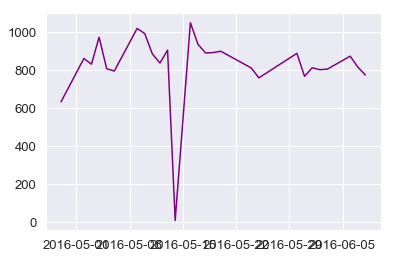

In [12]:
plt.plot(ts.groupby(['AppointmentDay'])['NoShow'].sum(), color="purple")

## Modeling and Evaluation 3

#### [20 points] Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

**Meeting Notes**: 1. Random Forest 2. SVM (radial) maybe and 3. Logistic
Chris to ask Dr Drew about clarification of which models we can use. SVM as radial. Check Naive Bayes is an option

## Modeling and Evaluation 4

#### [10 points] Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

**Meeting Notes**  Precision, recall, F-measure, ROC, AUC

## Modeling and Evaluation 5

#### [10 points] Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course

## Modeling and Evaluation 6

#### [10 points] Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## Deployment (5 points total) 

#### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Exceptional Work (10 points total) 

#### You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

**Meeting Notes** - We did this in MiniLab 1 with chart 
Possible to add Naives Bayes classification (Luay)